In [344]:
import pandas as pd
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [345]:
impute = True

In [346]:
# df = pd.read_csv("../data/test.csv", parse_dates=['timestamp'],index_col="id")
raw_test = pd.read_csv("../data/test.csv", parse_dates=['timestamp'],index_col="id")
locales = pd.read_csv("../data/okurg.csv")



In [347]:
# top fields from Grant's xgb
fields = ['timestamp','kremlin_km','full_sq', 'life_sq', 'kitch_sq', 'floor', 'max_floor', 'build_year', 
          'num_room', 'state','material','sub_area']

all_cols = True

In [348]:

if all_cols:
    df = raw_test.copy()
else:
    df = raw_test.loc[:,fields]
    
df = pd.merge(df,locales, how="left", on="sub_area").reset_index(drop=True).set_index(df.index)

## Thoughts
* outliers?
    df[df.life_to_full<.25]
    

# Missingness Overview

In [349]:
print "shape of data {}".format(df.shape)
missing = df.isnull()
print "num cols missing {}".format(sum(missing.any(axis=0)))
print "num rows missing {}".format(sum(missing.any(axis=1)))
print "rows with missing {:.2f}%".format(100. * sum(missing.any(axis=1))/len(df))
print "\n"
cols = ['full_sq', 'life_sq', 'kitch_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'state','sub_area']
for col in cols:
    print "number of missing {} {}".format(col,sum(df[col].isnull()))

shape of data (7662, 291)
num cols missing 48
num rows missing 5244
rows with missing 68.44%


number of missing full_sq 0
number of missing life_sq 1176
number of missing kitch_sq 0
number of missing floor 0
number of missing max_floor 0
number of missing build_year 1049
number of missing num_room 0
number of missing state 694
number of missing sub_area 0


### Helper Functions

In [350]:
def getKremlinGroup(df, id):
    """ returns the group that are the same distance from the kremlin"""
    x = df.loc[id,'kremlin_km']
    return df.loc[df.kremlin_km==x,:]
    

## Initial changes
Drop some initial outliers
    * full_sq < 10 set to nan
    * life > full both to nan
    * kitch > full both to nan
    * kitch > life both to nan
    * kitch > 200 to nan
    * floor == 0 to nan
    * max_floor == 0 to nan
    * max_floor < floor to nan
    * build_year 
        * 1500 < build_year > 2018 to nan
    * num_room == 0 to nan

    

In [351]:
def printStats(test):
    print "number that full_sq > 450 : ", len(test[test.full_sq > 450])
    print "number that full_sq < 10 : ", len(test[test.full_sq < 10])
    print "number that full < life : ", len(test[test.full_sq < test.life_sq])
    print "number that full < kitch : ", len(test[test.full_sq < test.kitch_sq])
    print "number that life < kitch : ", len(test[test.life_sq < test.kitch_sq])
    print "number that kitch > 200 : ", len(test[test.kitch_sq > 200])
    print "number that kitch <= 1 : ", len(test[test.kitch_sq <= 1])

    print "number that floor == 0 : ", len(test[test.floor == 0])
    print "number that floor > 70 : ", len(test[test.floor > 70])
    print "number that max_floor > 70 : ", len(test[test.max_floor > 70])
    print "number that max_floor == 0 : ", len(test[test.max_floor == 0])
    print "number that max_floor < floor : ", len(test[test.max_floor < test.floor])
    print "number that num_room == 0 : ", len(test[test.num_room == 0])
    print "number that build_year <=1  : ", len(test[test.build_year <= 1])

## Possible Wrong Values

In [352]:
ints = df[(df.full_sq * 10 % 10 == 0)].sort_values('full_sq',ascending=False)
floats = df[(df.full_sq * 10 % 10 != 0)].sort_values('full_sq',ascending=False)

print "How many have the full_sq as an integer e.g. 34.0 and not 34.1:  ", len(ints)
print "How many have the full_sq as an floats ", len(floats)

How many have the full_sq as an integer e.g. 34.0 and not 34.1:   713
How many have the full_sq as an floats  6949


In [353]:
df.loc[df.full_sq<df.life_sq,:]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

These below have screwed up full_sq values

In [354]:
rows = [35108,30938,35857,36824]
print "before"
# changed the max to 53

print df.loc[rows,['full_sq','life_sq']]

df.loc[35108,'full_sq'] = 40.3 
df.loc[35108,'life_sq'] = np.nan 

df.loc[30938,'full_sq'] = 37.80 ## was 0

df.loc[35857, 'full_sq'] = 76.0 ## was 1 selected 76.0 (common sq in the group)

df.loc[36824, 'full_sq'] = 55 ## was 2, took ~ mean of the group

df.loc[36824, 'life_sq'] = np.nan 

print "after"
print df.loc[rows,['full_sq','life_sq']]

before
       full_sq  life_sq
id                     
35108    403.0     1.00
30938      0.0    37.80
35857      1.0    42.07
36824      2.0     2.00
after
       full_sq  life_sq
id                     
35108     40.3      NaN
30938     37.8    37.80
35857     76.0    42.07
36824     55.0      NaN


Life appears to be off a digit below

In [355]:
rows = [31075, 32370, 32505, 33265, 35661]

print "before"
print df.loc[rows,['full_sq','life_sq']]


df.loc[rows,'life_sq'] = df.loc[rows,'life_sq'] / 10

print "after"
print df.loc[rows,['full_sq','life_sq']]

before
       full_sq  life_sq
id                     
31075     74.2    742.0
32370     36.1    361.0
32505     40.2    237.0
33265     86.9    869.0
35661     56.3    283.0
after
       full_sq  life_sq
id                     
31075     74.2     74.2
32370     36.1     36.1
32505     40.2     23.7
33265     86.9     86.9
35661     56.3     28.3


Rows below look like values are reversed

In [356]:
# look like the values are reverses
rows = [30593, 32501, 30645, 33278, 30538]
print "before"
print df.loc[rows,['full_sq','life_sq']]

new_full = df.loc[rows,"life_sq"].copy()
new_life = df.loc[rows,"full_sq"].copy()
df.loc[rows,"full_sq"] = new_full
df.loc[rows,"life_sq"] = new_life

print "after"
print df.loc[rows,['full_sq','life_sq']]

before
       full_sq  life_sq
id                     
30593   100.04   104.28
32501    51.90    93.20
30645    57.80    60.00
33278    14.80    33.80
30538    29.80    30.60
after
       full_sq  life_sq
id                     
30593   104.28   100.04
32501    93.20    51.90
30645    60.00    57.80
33278    33.80    14.80
30538    30.60    29.80


In [357]:
# np.nan for kitchens larger than full_sq
df.loc[df.kitch_sq>df.full_sq,'kitch_sq'] = np.nan
df.loc[df.life_sq<=1, 'life_sq'] = np.nan
df.loc[df.kitch_sq<=1, 'kitch_sq'] = np.nan

In [358]:
df = df.assign(room_size = lambda df: df.life_sq / df.num_room)

In [359]:
print "Test data stats"
printStats(df)

Test data stats
number that full_sq > 450 :  0
number that full_sq < 10 :  0
number that full < life :  0
number that full < kitch :  0
number that life < kitch :  7
number that kitch > 200 :  0
number that kitch <= 1 :  0
number that floor == 0 :  0
number that floor > 70 :  0
number that max_floor > 70 :  0
number that max_floor == 0 :  233
number that max_floor < floor :  643
number that num_room == 0 :  0
number that build_year <=1  :  556


In [360]:
df.loc[df.full_sq == df.kitch_sq, 'kitch_sq'] = np.nan 

In [361]:
# i think these are switched

rows = [31014,32266]
print "before"
print df.loc[rows,['full_sq','life_sq','kitch_sq']]

df.loc[rows,'life_sq'] = 28.3
df.loc[rows,'kitch_sq'] = 13.4

print "after"
print df.loc[rows,['full_sq','life_sq','kitch_sq']]

before
       full_sq  life_sq  kitch_sq
id                               
31014     53.8     13.4      28.3
32266     53.8     13.4      28.3
after
       full_sq  life_sq  kitch_sq
id                               
31014     53.8     28.3      13.4
32266     53.8     28.3      13.4


In [362]:
# i think these are switched

rows = [34769,36474,37703]
print "before"
print df.loc[rows,['full_sq','life_sq','kitch_sq']]

df.loc[rows,'life_sq'] = df.loc[rows,'kitch_sq'].copy()
df.loc[rows,'kitch_sq'] = np.nan

print "after"
print df.loc[rows,['full_sq','life_sq','kitch_sq']]

before
       full_sq  life_sq  kitch_sq
id                               
34769     54.1     18.3      19.0
36474     39.2     12.0      15.3
37703     44.7     13.2      16.2
after
       full_sq  life_sq  kitch_sq
id                               
34769     54.1     19.0       NaN
36474     39.2     15.3       NaN
37703     44.7     16.2       NaN


### Max vs Floor
floor > max_floor

Looks like the distribution of floors is off in the missing data. I think the columns are acutally switched.
Like the rows with messed up sq feet, there are a lot of 1s and 0s that come from the Novomoskovsky region.

I think the 0s and 1s are nan here too

left Floor distribution of questionable ones, floor>max and floor > 1
right floor distribution for floor < max and floor > 1


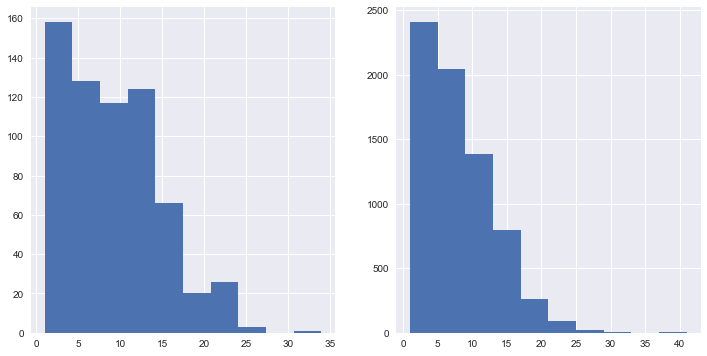

In [363]:
missing = df[(df.floor>df.max_floor)]
missing = missing.drop(['timestamp','sub_area','okurg_district'],axis=1)


fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
missing.floor.hist(ax=axs[0])
print "left Floor distribution of questionable ones, floor>max and floor > 1"
print "right floor distribution for floor < max and floor > 1"

df[(df.max_floor>=df.floor)].floor.hist(ax=axs[1])

left: max_floor distribution of the questionable data, floor > max_floor 
right: max_floor distribution of good data, floor < max


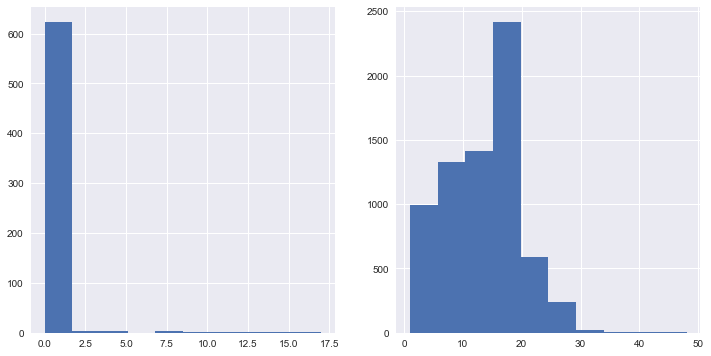

In [364]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
missing.max_floor.hist(ax=axs[0])
print "left: max_floor distribution of the questionable data, floor > max_floor "
print "right: max_floor distribution of good data, floor < max"
df[(df.max_floor>=df.floor)].max_floor.hist(ax=axs[1])

Again, the number of 0s are heavily in teh Novosmoky region

In [365]:
max_floor_0 = df[df.max_floor == 0].okurg_district.value_counts()
max_floor_1 = df[df.max_floor == 1].okurg_district.value_counts()
bad = pd.concat([max_floor_0.to_frame(),max_floor_1.to_frame()],axis=1)
bad.columns = ["max_floor_0","max_floor_1"]
bad.sort_values('max_floor_0',ascending=False)

,max_floor_0,max_floor_1
Novomoskovsky,160,112
Southern,24,18
South Eastern,9,4
Western,9,45
Central,8,99
North Eastern,6,48
Northern,4,10
South Western,3,5
Troitsky,3,9
Zelenograd,3,30


In [366]:
df[df.max_floor>1].max_floor.value_counts()

17    1827
9     1004
5      766
12     737
14     439
16     425
25     221
22     218
24     180
15     132
3      127
10     120
20     117
8      107
18      95
19      69
4       58
7       58
13      57
11      57
23      48
6       43
2       36
21      28
30      16
29       7
26       7
48       6
40       5
27       4
35       3
33       2
31       2
39       1
28       1
32       1
37       1
38       1
41       1
Name: max_floor, dtype: int64

In [367]:
df.loc[df.max_floor==0,'max_floor'] = np.nan

### floor > max_floor and max_floor > 1
I think these columns are mixed up because the floor is a freuqent max floor in the good columns

In [368]:
bad = df[(df.floor>df.max_floor) & (df.max_floor > 1)].copy()
bad

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [369]:
new_max = bad.floor.copy()
new_floor = bad.max_floor.copy()
df.loc[bad.index,'max_floor'] = new_max
df.loc[bad.index,'floor'] = new_floor
df.loc[bad.index,:]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [370]:
krems = df[df.floor<df.max_floor].kremlin_km.unique()
kremGroups = df[df.floor<df.max_floor].groupby('kremlin_km').max_floor.value_counts(normalize=True)
kg_dict = {x:{} for x in krems}


In [371]:
for x in kremGroups.iteritems():
    km = x[0][0]
    floor = x[0][1]
    ratio = x[1]
    kg_dict[km][floor] = ratio 

In [372]:
bad_floors = df[df.floor>df.max_floor]

def getMaxFloorCounts(kremlin_km,floor):
    x = kg_dict.get(kremlin_km,None)
    if x:
        return x.get(floor,np.nan)
    else:
        return np.nan

In [373]:
bad_floors['floor_freq_in_max'] = bad_floors.apply(lambda x: getMaxFloorCounts(x['kremlin_km'],x['floor']),axis=1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [374]:
bad_floors = df[df.floor>df.max_floor].floor.value_counts().to_frame()
good_floors = raw_test[raw_test.floor<raw_test.max_floor].floor.value_counts(normalize=True).to_frame()

In [375]:
floors = pd.concat([bad_floors,good_floors],axis=1)
floors.columns = ['bad_floor_counts','frequencey_in_good_data']
floors.sort_values('bad_floor_counts',ascending=False)

,bad_floor_counts,frequencey_in_good_data
3.0,34.0,0.101262
4.0,30.0,0.095115
7.0,29.0,0.072145
2.0,27.0,0.105629
8.0,27.0,0.076027
9.0,26.0,0.049499
14.0,25.0,0.029602
6.0,25.0,0.072145
5.0,25.0,0.071821
11.0,23.0,0.049175


So it looks like the higher ones are definitely off, the problem is with the ones less than 5. <br>
Let's look at the distribution before and after reversing the columns

left is good data before the flip and right is after the flip, not real change


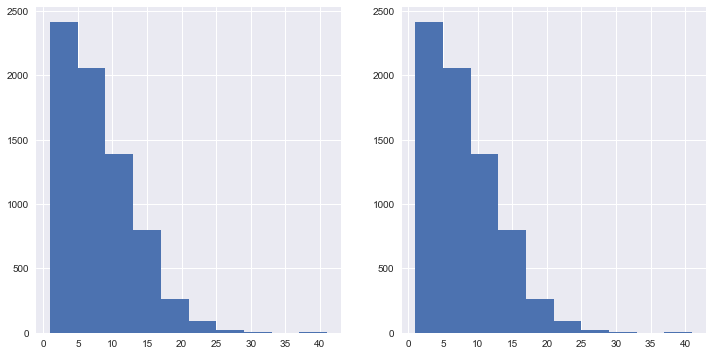

In [376]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
df[df.floor<=df.max_floor].floor.hist(ax=axs[0])
print "left is good data before the flip and right is after the flip, not real change"
temp = df.copy()
bad_index = temp[(temp.floor>temp.max_floor) & (temp.max_floor != 0)].index
new_floor = temp.loc[bad_index,'max_floor'].tolist()
new_max = temp.loc[bad_index,'floor'].tolist()
temp.loc[bad_index,'floor'] = new_floor
temp.loc[bad_index,'max_floor']= new_max

# distribution stays about the same after making this adjustment
temp[df.floor<=df.max_floor].floor.hist(ax=axs[1])

In [377]:
if impute:
    bad_floors = df[df.floor>df.max_floor].copy()
    indx = bad_floors.index

    # switching the floor columns 
    new_floor = df.loc[indx,'max_floor']
    new_max = df.loc[indx,'floor']
    
    bad_floors.loc[indx,'max_floor'] = new_max
    bad_floors.loc[indx, 'floor'] = new_floor
    df.loc[bad_floors.index,:] = bad_floors

else:
    bad_floors.loc[:,'max_floor'] = np.nan
# bad_floors.sort_values('max_floor')

# Imputing Missing Floors

### KNN Regression first

Want to give more weight to neighborhood, so adding another kremlin variable

In [378]:
cols = ['kremlin_km', 'full_sq', 'floor', 'max_floor']

complete = df.loc[~df[cols].isnull().any(axis=1),cols].copy()
complete['kremlin_km2'] = complete['kremlin_km']

missing = df.loc[df.max_floor.isnull(),cols].copy()
missing['kremlin_km2'] = missing['kremlin_km']
cols = ['kremlin_km', 'full_sq', 'floor','kremlin_km2']

missing = missing.loc[~missing[cols].isnull().any(axis=1),:]
prediction_inputs = missing.drop('max_floor',axis=1).copy()

In [379]:
predictGroups = prediction_inputs.groupby('floor')

In [380]:
for p in predictGroups:
    c = complete[complete.max_floor > p[0]]
    n = len(c)
        
    neigh = KNeighborsRegressor(n_neighbors=min(2,n))
    missing.loc[p[1].index,'max_floor_KNNR2'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsRegressor(n_neighbors=min(5,n))
    missing.loc[p[1].index,'max_floor_KNNR5'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsRegressor(n_neighbors=min(100,n))
    missing.loc[p[1].index,'max_floor_KNNR100'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

### Trying KNN with everything as a category

Set all columns to category because I wanted to find try and match up the exact building from the group. Rounded the sq meters to the closest 5 to improve the odds of matching.

In [381]:
def roundIt(x, base=5):
    return int(base * round(float(x)/base))

In [382]:
cols = ['kremlin_km', 'full_sq', 'floor','kremlin_km2']

# make the sq round so it's easier to match 
missing['full_sq'] = missing['full_sq'].apply(roundIt)

## drop all rows with missing in anything except max_floor
prediction_inputs = missing[cols].apply(lambda x: x.astype('category'),axis=0)

predictGroups = prediction_inputs.groupby('floor')

for p in predictGroups:
    c = complete[complete.max_floor > p[0]]
    n = len(c)

    neigh = KNeighborsClassifier(n_neighbors=min(2,n))
    missing.loc[p[1].index,'max_floor_KNNC2'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsClassifier(n_neighbors=min(5,n))
    missing.loc[p[1].index,'max_floor_KNNC5'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsClassifier(n_neighbors=min(100,n))
    missing.loc[p[1].index,'max_floor_KNNC100'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])



## Selecting Max_floor
Selected the max floor based on the mode from all of the KNN observations

In [383]:
missing = missing.apply(pd.to_numeric)
for col in missing.columns[6:12]:
    missing.loc[missing[col] < missing.floor, col] = np.nan

In [384]:
missing.max_floor = missing.iloc[:,6:12].mode(axis=1,numeric_only=True)

In [385]:
if impute:
    df.loc[missing.index,'max_floor'] = missing.max_floor

In [386]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [387]:
# cols = ['full_sq','floor','max_floor']
# # df.sort_values('full_sq',ascending=False)
# df.drop('room_size',axis=1).to_csv('../data/clean_test_chase.csv')

## Missing SQ

In [388]:
print "num missing life_sq", sum(df.life_sq.isnull())
print "num missing kitch_sq", sum(df.kitch_sq.isnull())

num missing life_sq 1506
num missing kitch_sq 2151


In [389]:
df = df.assign(life_to_full = lambda df: df.life_sq / df.full_sq)
df = df.assign(kitch_to_life = lambda df: df.kitch_sq / df.life_sq)

In [404]:
df.loc[df.life_to_full<.15,'life_sq'] = np.nan 

missing = df[df.life_sq.isnull() | df.kitch_sq.isnull()].copy()

### Will use median of the dist group ratios to impute missingness
first life_sq

In [405]:
df.loc[df.full_sq == 0,'full_sq'] = np.nan
df.loc[df.full_sq<df.life_sq,'full_sq'] = np.nan
df = df.assign(life_to_full = lambda df: df.life_sq / df.full_sq)
df = df.assign(kitch_to_life = lambda df: df.kitch_sq / df.life_sq)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11671da90>]], dtype=object)

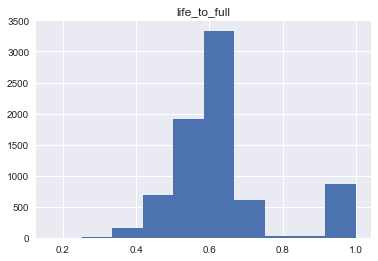

In [406]:
# Similiar to the uncleaned test datat
df.hist('life_to_full')

In [407]:
cols = ['kremlin_km', 'full_sq','life_sq','life_to_full','floor', 'sub_area']
complete = df.loc[~df[cols].isnull().any(axis=1),cols].copy()

# split the missing in to groups first by neighborhoods and then by area
missingGroupsKrem = missing.groupby('kremlin_km')
missingGroupsSubArea = missing.groupby('sub_area')

for g in missingGroupsKrem:
    nhood = complete[complete.kremlin_km == g[0]]
    boro = complete[complete.sub_area == g[1].sub_area.unique().tolist()[0]]
    
    ratio = np.nanmedian(nhood.life_to_full)
    
    # first check hood and then boro, finally overall
    if len(nhood) < 3 and len(boro) > 5:
        ratio = np.nanmedian(boro.life_to_full)
    else:
        ratio = np.nanmedian(df.life_to_full)
        
    missing.loc[g[1].index,'life_sq'] = g[1].full_sq * ratio

### Kitch_sq
going to do the same for kitch_sq 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c498a90>]], dtype=object)

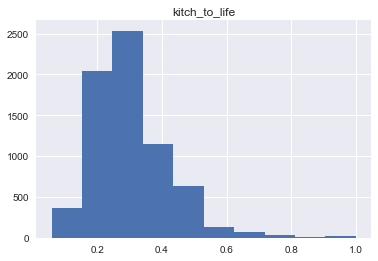

In [409]:
df[df.kitch_sq>0].hist('kitch_to_life')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a423850>]], dtype=object)

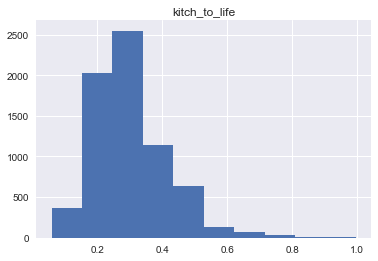

In [410]:
# distribution is about 20-30%
df[(df.kitch_to_life>0) & (df.kitch_to_life<1)].hist('kitch_to_life')

In [411]:
cols = ['kremlin_km','life_sq','kitch_sq','kitch_to_life','floor', 'sub_area']
complete = df.loc[~df[cols].isnull().any(axis=1),cols].copy()

missingGroupsKrem = missing.groupby('kremlin_km')
missingGroupsSubArea = missing.groupby('sub_area')

for g in missingGroupsKrem:
    nhood = complete[complete.kremlin_km == g[0]]
    boro = complete[complete.sub_area == g[1].sub_area.unique().tolist()[0]]
    
    ratio = np.nanmedian(nhood.kitch_to_life)
    
    # first check hood and then boro, finally overall
    if len(nhood) < 3 and len(boro) > 5:
        ratio = np.nanmedian(boro.kitch_to_life)
    else:
        ratio = np.nanmedian(df.kitch_to_life)
    
    missing.loc[g[1].index,'kitch_sq'] = g[1].life_sq * ratio

In [412]:
cols = ['life_sq','kitch_sq','floor','max_floor']
df.loc[missing.index,cols] = missing.loc[:,cols]

In [413]:
print "before "
print df.loc[38128,['full_sq','life_sq','kitch_sq']]
df.loc[38128,'life_sq'] = df.loc[38128,'full_sq'] * np.nanmedian(df.life_to_full)
df.loc[38128,'kitch_sq'] = df.loc[38128,'life_sq'] * np.nanmedian(df.kitch_to_life)

print "after"
print df.loc[38128,['full_sq','life_sq','kitch_sq']]

before 
full_sq       23.56
life_sq     14.0157
kitch_sq    3.91968
Name: 38128, dtype: object
after
full_sq       23.56
life_sq     14.0157
kitch_sq    3.91968
Name: 38128, dtype: object


In [414]:
raw_test.shape

(7662, 290)

In [415]:
print sum(df.life_sq.isnull())
print sum(df.kitch_sq.isnull())

0
0


In [420]:
cols = ['full_sq','life_sq','max_floor', 'kitch_sq', 'floor', 'sub_area', 'timestamp']
x = df.isnull().any(axis=0)

df[x[~x].index.tolist()].to_csv('../Chase/clean_test_chase_all_cols.csv')

### Stop here

# Missing Build Year

In [171]:
add_multiples(df)

In [172]:
df['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('Q%q-%y')

In [173]:
dfg = df.loc[:,['quarter','okurg_district','price_full']].groupby('okurg_district')

In [174]:
md = dfg.aggregate(np.nanmedian)

In [175]:
x = np.log(df.price_doc)
y = np.log(df.price_doc + 1)

In [176]:
print(x[0:10])
print(y[0:10])

id
7675    16.128046
8138    16.012735
8156    15.763069
8157    15.775605
8171    15.243067
8178    15.679591
8258    16.308716
8285    15.856731
8290    16.275099
8296    14.285514
Name: price_doc, dtype: float64
id
7675    16.128046
8138    16.012735
8156    15.763069
8157    15.775605
8171    15.243067
8178    15.679591
8258    16.308716
8285    15.856731
8290    16.275099
8296    14.285515
Name: price_doc, dtype: float64


In [229]:
add_multiples(df)

In [231]:
df.sort_values('price_full_std',ascending=False).head()

,timestamp,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,price_full_std
id,,,,,,,,,,,,
1,2011-08-20,5850000,15.156211,43,27.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
2,2011-08-23,6000000,8.698054,34,19.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,2011-08-27,5700000,9.067885,43,29.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN
4,2011-09-01,13100000,19.487005,89,50.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN
5,2011-09-05,16331452,2.578671,77,77.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN


In [238]:
# looks like a price outlier $3.7m for a 500 sq ft apt
# update price
# add_multiples(df)

In [178]:
bad_sq = df.query('full_sq < life_sq or life_sq < kitch_sq or full_sq.isnull()')

In [929]:
# change all full and life <= 10 to NaN
df.loc[df.full_sq < 10,'full_sq'] = np.nan
df.loc[df.life_sq < 10,['life_sq','kitch_sq']] = np.nan

df.loc[(df.kitch_sq >= df.life_sq), 'kitch_sq'] = np.nan
df.loc[(df.kitch_sq >= df.full_sq),'kitch_sq'] = np.nan

### Square Meter (full_sq, life_sq, kitch_sq)

Added price to square meters columns to help identify outliers
#### Adjustments
    * full and life < 10 are set to np.nan (10 is about a 100 sq foot apt)
    * full < life check to see which one appears to be the incorrect value based on price multiples stds.

kitchens with 0 or 1 maybe studio apts

In [931]:
df.sort_values('full_sq', ascending=False).head()

,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3530,6868818,16.139809,5326.0,22.0,NaN,13.0,NaN,NaN,NaN,NaN,0.780191,0.499398,0.699257,NaN,4.907833,2.149384,Birjulevo Vostochnoe,0.214503,28.439791,0.228109,0.841827,3.381655,2012-09-07,Southern,1289.676680,312219.000000,NaN,NaN,0.004131,NaN
2783,13250000,12.307897,729.0,44.0,NaN,12.0,NaN,NaN,NaN,NaN,0.136485,0.023740,0.426871,NaN,2.685885,0.564859,Troparevo-Nikulino,1.415226,22.127146,0.119978,1.383085,2.488351,2012-07-06,Western,18175.582990,301136.363636,NaN,NaN,0.060357,NaN
22788,4725142,0.072897,637.0,637.0,10.0,18.0,19.0,2016.0,2.0,1.0,1.048962,0.189089,0.269716,4.0,1.482746,2.608162,Tverskoe,2.640803,13.459068,0.326035,2.566044,1.421099,2014-09-23,Central,7417.805338,7417.805338,NaN,NaN,1.000000,0.015699
18344,6213200,20.549464,634.0,NaN,0.0,3.0,17.0,NaN,2.0,NaN,0.286711,0.017572,0.214197,1.0,4.721045,5.422551,Nekrasovka,0.394108,45.322032,0.035986,1.214861,8.106936,2014-05-13,South Eastern,9800.000000,NaN,NaN,NaN,NaN,NaN
5947,10200000,16.292579,634.0,38.0,NaN,3.0,NaN,NaN,NaN,NaN,0.025172,0.121641,0.353390,NaN,1.746993,1.566321,Lianozovo,1.063524,8.067791,0.204624,1.426593,2.029415,2013-02-07,North Eastern,16088.328076,268421.052632,NaN,NaN,0.059937,NaN


#### Checking life_sq for possible wrong inputs

In [935]:
off = df[df.full_sq < df.life_sq].sort_values('life_sq', ascending=False)[0:15]
# off

In [936]:
# these appear to be off a digit 
off_index = off[0:13].index
if impute:
    df.loc[13549,'life_sq'] = df.loc[13549,'life_sq'] / 10 # off two digits
    df.loc[off_index,'life_sq'] = df.loc[off_index,'life_sq']/10
else:
    df.loc[off_index,'life_sq'] = np.nan

In [937]:
# df.loc[off.index,:]

### Full vs Life
when full < life, take the one that seems like less of an outlier 

In [938]:
bad_df = df[df.full_sq < df.life_sq]
print "number of rows " , len(bad_df)
bad_df.head()

number of rows  17


,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1825,5200000,13.635361,18.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,0.228476,0.075926,0.313596,NaN,2.334253,1.624978,Ljublino,1.083078,21.636236,0.103915,2.416847,3.217099,2012-04-09,South Eastern,288888.888889,136842.105263,2.840665,-0.842502,NaN,NaN
6534,13801229,13.143751,80.0,88.0,NaN,9.0,NaN,NaN,NaN,NaN,1.424717,0.646005,0.510474,NaN,3.405352,0.742342,Pokrovskoe Streshnevo,0.443602,27.479760,0.110209,0.713374,3.781754,2013-03-15,North Western,172515.362500,156832.147727,0.722707,-0.665888,NaN,NaN
6996,6290256,20.549464,73.0,77.0,NaN,10.0,NaN,NaN,NaN,NaN,0.286711,0.017572,0.214197,NaN,4.721045,5.422551,Nekrasovka,0.394108,45.322032,0.035986,1.214861,8.106936,2013-04-03,South Eastern,86167.890411,81691.636364,-0.848787,-1.329762,NaN,NaN
8104,3622465,20.549464,37.0,38.0,NaN,8.0,NaN,NaN,NaN,NaN,0.286711,0.017572,0.214197,NaN,4.721045,5.422551,Nekrasovka,0.394108,45.322032,0.035986,1.214861,8.106936,2013-05-23,South Eastern,97904.459459,95328.026316,-0.635186,-1.209283,NaN,NaN
9485,3000000,13.687390,52.0,53.0,8.0,12.0,1.0,1983.0,2.0,3.0,0.194483,0.030993,0.298627,1.0,3.198813,2.625650,Juzhnoe Medvedkovo,0.484628,25.427899,0.137156,0.659250,5.202360,2013-07-27,North Eastern,57692.307692,56603.773585,-1.367033,-1.551417,NaN,0.150943


In [939]:
sum(df.full_sq.isnull())

7

## Life_sq > Full_sq???
select the one that seems like the least of an outlier based on price to sq

In [940]:
# select full and np.nan life if price to full is more reasonable
full_ind = bad_df[abs(bad_df.price_to_full_std) < abs(bad_df.price_to_life_std)].index

# select life and np.nan full if price to full is more reasonable
life_ind = [x for x in bad_df.index if x not in full_ind]

df.loc[full_ind, 'life_sq'] = np.nan
df.loc[life_ind, 'full_sq'] = np.nan


# updating multiples
add_multiples(df)

In [941]:
# df[df.life_sq.isnull()]

#### Characteristics by Neighborhood
Grouped the data by subset and will take the median neighborhood ratios of sq meters to impute missingness

In [942]:
df.loc[[27398,30446],:]

,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27398,6489774,16.957155,62.0,NaN,NaN,13.0,17.0,NaN,2.0,1.0,0.230087,0.360319,0.044599,1.0,3.343157,1.242741,Solncevo,0.631064,24.450869,0.257288,0.874445,2.128289,2015-01-21,Western,104673.774194,NaN,-0.511887,NaN,NaN,NaN
30446,7567425,16.957155,79.0,NaN,NaN,17.0,17.0,NaN,3.0,1.0,0.230087,0.360319,0.044599,1.0,3.343157,1.242741,Solncevo,0.631064,24.450869,0.257288,0.874445,2.128289,2015-06-27,Western,95790.189873,NaN,-0.673618,NaN,NaN,NaN


In [943]:
dfg = df.groupby('sub_area')
life_full_dict = dfg['life_to_full'].aggregate('median').to_dict()
kitch_life_dict = dfg['kitch_to_life'].aggregate('median').to_dict()

In [944]:
# impute the missing sq by using the sub areas 

mis_full_index = df[df.full_sq.isnull()].index
mis_life_index = df[df.life_sq.isnull()].index
mis_kitch_index = df[df.kitch_sq.isnull() | (df.kitch_sq > df.life_sq)].index

if impute:
    # update the life_to_full ratio from median of subareas
    df.loc[mis_full_index,'life_to_full'] = [life_full_dict[x] for x in df.loc[mis_full_index,'sub_area']]
    df.loc[mis_life_index,'life_to_full'] = [life_full_dict[x] for x in df.loc[mis_life_index,'sub_area']]
    df.loc[mis_kitch_index,'kitch_to_life'] = [kitch_life_dict[x] for x in df.loc[mis_kitch_index,'sub_area']]
    
    # impute sq based off of ratio
    df.loc[mis_full_index,:] = df.loc[mis_full_index,:].assign(full_sq = lambda x: x.life_sq / x.life_to_full)
    df.loc[mis_life_index,:] = df.loc[mis_life_index,:].assign(life_sq = lambda x: x.full_sq * x.life_to_full)
    df.loc[mis_kitch_index,:] = df.loc[mis_kitch_index,:].assign(kitch_sq = lambda x: x.life_sq * x.kitch_to_life)

In [945]:
add_multiples(df)

### Building characteristics
Imputations: 
    Years = change every build year less than 1875 to 1875

In [947]:
if impute:
    df.loc[df.build_year < 1875, 'build_year'] = 1875
    df.loc[df.build_year==1, 'build_year'] = 2001
    df.loc[df.build_year==3, 'build_year'] = 2003
    df.loc[df.build_year==20, 'build_year'] = 2000
    df.loc[df.build_year==71, 'build_year'] = 1971
    df.loc[df.build_year==215, 'build_year'] = 2015
    df.loc[15223,'build_year'] = 1965
    df.loc[10092,'build_year'] = 2005
    df.loc[10093,'build_year'] = 2009

#### If max floor is nan
try a random sample from first the group by distance else the DF set

In [983]:
bad = df[df.max_floor.isnull()].index
if impute:
    df.loc[bad,"max_floor"] = [imputeMaxFloor(x) for x in bad]

In [989]:
np.random.randint(15)

8

In [991]:
bad = df[df.floor.isnull()].index
if impute:
    df.loc[bad,'floor'] = [np.random.randint(df.loc[x,'max_floor']) for x in bad]

### Looking at missing year
first see if it matches any other buildings by max_floor in the dist group

In [42]:
df.head()

,timestamp,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,material,sub_area,okurg_district,life_to_full,kitch_to_life,diff_full_life
id,,,,,,,,,,,,,,,,,
1,2011-08-20,5850000,15.156211,43.0,27.0,NaN,4.0,5.0,NaN,NaN,NaN,NaN,Bibirevo,North Eastern,0.627907,NaN,16.0
2,2011-08-23,6000000,8.698054,34.0,19.0,NaN,3.0,9.0,NaN,NaN,NaN,NaN,Nagatinskij Zaton,Southern,0.558824,NaN,15.0
3,2011-08-27,5700000,9.067885,43.0,29.0,NaN,2.0,5.0,NaN,NaN,NaN,NaN,Tekstil'shhiki,South Eastern,0.674419,NaN,14.0
4,2011-09-01,13100000,19.487005,89.0,50.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,Mitino,North Western,0.561798,NaN,39.0
5,2011-09-05,16331452,2.578671,77.0,77.0,NaN,4.0,8.0,NaN,NaN,NaN,NaN,Basmannoe,Central,1.000000,NaN,0.0


In [1219]:
ms_distances = missing.kremlin_km.unique()

In [1262]:
for d in ms_distances:
    c = complete[complete.kremlin_km == d]
    
    # check to make sure there are enough observations in the complete group, if not use total complete
    if len(c) < 3:
        c = complete
    m = missing[missing.kremlin_km == d]
    n = int(math.sqrt(len(c)))

    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(c.drop('floor', axis=1),c.floor)
        
    missing.loc[m.index,'floor'] = neigh.predict(m.drop('floor', axis=1))


In [1266]:
if impute:
    df.loc[missing.index,'floor'] = missing.floor